# 10/25/2020

Pendulum example taken from Barber

The physical model of a pendulum is $$ x_t = \sin \left(\theta t\right) $$ where $ \theta = \sqrt{g/L} $ is the angular frequency of the pendulum, a constant dependent upon the physical parameters of the system, namely the length of the pendulum (mass should also be included). The dynamic variable here is $x_t$, the angular displacement at time $t$.

If we have an imperfect measurement device, our data will consist of measurements of $x$ which do not precisely fit our model. We can use a perturbed model $$ x_t = \sin \left(\theta t\right) + \epsilon_t $$ where $$ \epsilon_t \sim \mathcal{N}\left(0,\sigma^2\right) $$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pymc3 as pm

In [2]:
g = 9.81
L = 3.45 

theta_exact = np.sqrt(g/L)

# generate some dummy data 

t = 10*np.random.rand(80)
X = np.sin(theta_exact * t)
sigma2 = .2
X_noisy = X+sigma2*np.random.randn(X.shape[0])

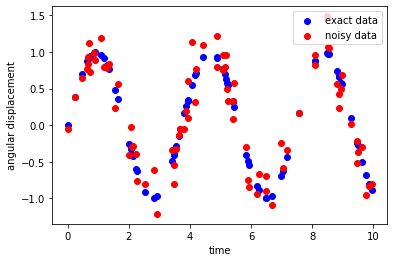

In [3]:
fig, ax = plt.subplots()
ax.scatter(t,X, color='b', label='exact data')
ax.scatter(t,X_noisy, color='r', label='noisy data')
ax.set(xlabel="time", ylabel="angular displacement",)
ax.legend()
plt.show()

We would like to infer what the parameter $\theta$ is, given some data. Since the data is noisy, we would like to factor in this uncertainty by obtaining a distribution over possible $\theta$ values. This is the posterior distribution $$ p\left(\theta\middle| x_1,x_2,\ldots,x_N\right) $$

Using Bayes's rule, we can rewrite this: $$ p\left(\theta\middle| x_1,x_2,\ldots,x_N\right) = \frac{p\left(x_1,\ldots,x_N \middle| \theta\right) p\left(\theta\right)}{p\left(x_1,\ldots,x_N\right)} \propto p\left(x_1,\ldots,x_N \middle| \theta\right) p\left(\theta\right) $$

The first term on the right is the data likelihood, under our model (which is defined by $\theta$). Since we assume observations are independent, we have $$ p\left(x_1,\ldots,x_N\middle| \theta\right) = \prod_{i=1}^N p\left(x_i\middle|\theta\right)$$

If the observations were precise, these probabilities would not even make sense (?). In our case, though, since our observations are imprecise, the best we can do is to prescribe a distribution over the possible values of $x_i$, given $\theta$. From the equation $$ x_t = \sin\left(\theta t\right) + \epsilon_t, $$ we have that $x_t$ is normally distributed about (the mean) $\sin\left(\theta t\right)$: $$ p\left(x_t\middle| \theta\right) = \mathcal{N}\left(x_t; \sin\left(\theta t\right), \sigma^2\right) $$ (Note that $\sigma^2$ is the variance in our observations (measurements), and it appears here. Thus, with a better measurement device, we would expect smaller $\sigma^2$ and thus the possible values of $x_t$ would be more closely grouped around the value predicted by the physical model, $\sin\left(\theta t\right)$.)

The second term is the prior distribution over $\theta$. This term represents our initial belief in the relative plausibilities of various values of $\theta$. For example, if we know that the length of our pendulum lies in some particular range, we could use this prior distribution to encode this information.


For example, in the toy data above, we specified the exact values $g=9.81$ and $L = 3.45$, resulting in the exact parameter value $\theta = \sqrt{\frac{g}{L}} \approx 1.686 $. Pretend that we do have some information: we know that the pendulum's length is between $1$ and $5$ units of length. This corresponds to a range of $\theta$ of $\left[1.401,3.132\right] \approx \left[1.4, 3.1\right] $. Since we know this information, we can place a uniform prior distribution on $\theta$ over this interval: $$ \theta \sim \text{U}\left(1.4,3.1\right) $$  

### Prior predictive distribution

One handy way to check our choice of priors is to utilize the prior predictive distribution.

$$ p\left(x' \middle| \theta\right) = \int p\left(\theta, x'\right) \, d\theta = \int p\left(x'\middle|\theta\right)p\left(\theta\right)\, d\theta $$ This is a distribution over possible new observations, given that the model parameter $\theta$ takes on certain values; in particular, we let $\theta$ take on values sa specified by its prior distribution, hence "prior predictive distribution."

Specifically, this distribution assigns probability to a new observations by averaging its likelihood over all parameter values as specified by the prior.

This distribution can be useful: we can draw new "observations" from it and compare them with the actual data. Since this distribution only factors in our prior beliefs and not the actual data, the synthetic data we generate will give us an idea of how well our beliefs (and likelihood) model the problem.

In this problem, where the likelihood is normal and the prior is uniform, we have $$ p\left(x_t'\middle|\theta\right) = \frac{1}{3.1-1.4} \frac{1}{\sqrt{2\pi \sigma^2}} \int_{1.4}^{3.1} \exp\left(-\frac{1}{2\sigma^2}\left(x_t' - \sin\left(\theta t\right)\right)^2 \right)\, d\theta $$

This seems a little confusing. Looks like the data is actually $\left\{ \left(t,x_t\right)\right\}$.

In [4]:
with pm.Model() as pendulum_model:

    # prior
    theta = pm.Uniform("theta", lower=1.4, upper=3.1)

    # data is (t,X_noisy)
    likelihood = pm.Normal("likelihood", mu=np.sin(theta*t), sigma=sigma2, observed=X_noisy)
    

In [5]:
with pendulum_model:
    # trace = pm.sample(draws=3000,tune=1200)
    advi = pm.fit(method="advi", n=30000)
    trace = advi.sample(draws=4800)

Finished [100%]: Average Loss = 116.24


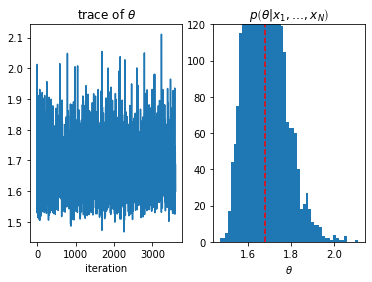

In [6]:
trace["theta"].shape

burn_in = 1200
theta_mean = np.mean(trace["theta"][burn_in:])

fig, ax = plt.subplots(ncols=2)
ax[0].plot(trace["theta"][burn_in:])
ax[1].hist(trace["theta"][burn_in:], bins=50,)
ax[1].vlines(theta_mean,0,120, color='r', linestyle='--')
ax[0].set(xlabel="iteration", title=r"trace of $\theta$")
ax[1].set(ylim=[0,120], xlabel=r"$\theta$", title=r"$p\left(\theta | x_1,\ldots,x_N\right)$")
plt.show()

In [7]:
L_pred = g/(theta_mean**2)

print("exact L:     {0:.4}".format(L))
print("predicted L: {0:.4}".format(L_pred))

exact L:     3.45
predicted L: 3.494


# Plot the likelihood for all $\theta$, the prior distribution over $\theta$

In [8]:
from scipy.stats import norm

def like(theta_val):
    # for this theta, get the value at each data point
    ll = 0
    for i in range(len(t)):
        ll += np.log(norm.pdf(X_noisy[i], loc=np.sin(theta_val * t[i]), scale=np.sqrt(sigma2))) # scale=stddev
    return(np.exp(ll/len(t)))

tt = np.arange(0,5,step=0.1)

dl = list(map(like, tt))


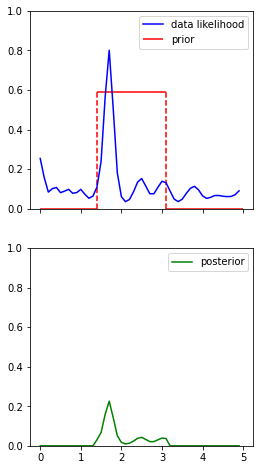

In [9]:
fig, ax = plt.subplots(figsize=(4,8), nrows=2, sharex=True)

a = 1/(3.1-1.4)
ax[0].hlines(0,1.4,0, color='r')
ax[0].hlines(a,1.4,3.1, color='r')
ax[0].hlines(0,3.1,5, color='r',label='prior')
ax[0].vlines(x=[1.4,3.1],ymin=0,ymax=a,linestyles="--", color='r')

ax[0].plot(tt,dl, color='b', label='data likelihood')
ax[0].set_ylim([0,1])
ax[0].legend()


def prior(x):
    if (x>=1.4) and (x<=3.1):
        return a
    else:
        return 0

post = np.zeros_like(tt)
for i in range(len(post)):
    post[i] = dl[i] * prior(tt[i])

post = post / np.sum(post)

ax[1].plot(tt,post, color='g', label="posterior")
ax[1].set_ylim([0,1])
ax[1].legend()
plt.show()




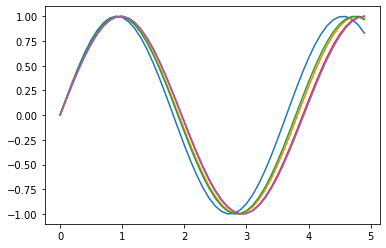

In [10]:
samples_theta = trace["theta"][-50::5]
samples_x = np.sin(tt[:,None] * samples_theta)

fig, ax = plt.subplots()

for i in range(5):
    ax.plot(tt, samples_x[:,i])